In [122]:
import jax.numpy as jnp
from jax import nn
import numpy as np
from matplotlib import pyplot as plt

from descent_methods import GD, SGD, SGD_adagrad, SGD_RMS_prop, SGD_adam
from utilities import MSELoss_method, jax_loss_grad, feature_matrix

In [123]:
# simple function
def f(x):
    return x + x**2

In [153]:
def sigmoid(x):
    return 1 / (1+jnp.exp(-x))

def relu(x):
    return jnp.maximum(0, x)

print(relu(np.array([-1, 2, 2, 0, -1])))

def leaky_relu(x, alpha = 0.5):
    return jnp.maximum(0, x) + alpha*jnp.minimum(x, 0)

print(leaky_relu(np.array([-1, 2, 2, 0, -1])))

def leaky_relu_stochastic(x, alpha_min=0, alpha_max=1):
    alpha = np.random.random(alpha_min, alpha_max)
    return leaky_relu(x, alpha=alpha)

print(leaky_relu_stochastic(np.array([-1, 2, 2, 0, -1])))
print(leaky_relu_stochastic(np.array([-1, 2, 2, 0, -1])))
print(leaky_relu_stochastic(np.array([-1, 2, 2, 0, -1])))

[0 2 2 0 0]
[-0.5  2.   2.   0.  -0.5]


TypeError: random() takes at most 1 positional argument (2 given)

In [133]:

num_points = 100

layers = [1, 10, 10, 200, 10 ,10, 1]

x = np.random.random((num_points, 1))*2
y = f(x)
beta0 = {}
for i in range(1,len(layers)):
    beta0[f"W{i}"] = np.random.random((layers[i-1], layers[i]))
    beta0[f"b{i}"] = np.random.random()

def neural_network(beta, X, activation = nn.sigmoid):
    out = X.copy()
    for i in range(1, len(beta.keys())//2):
        #print(f'{out.shape} + {beta[f"W{i}"].shape}')

        out = activation(jnp.add(jnp.dot(out, beta[f"W{i}"]), beta[f"b{i}"]))
        
        #out = jnp.dot(out, beta[f"W{i}"])
    out_final = jnp.add(jnp.dot(out, beta[f"W{len(beta.keys())//2}"]), beta[f"b{len(beta.keys())//2}"])
    #print(out.shape)
    return out_final


#beta0 = {"W1":np.random.random((num_params, 1))}

X = feature_matrix(x, layers[0])

print(neural_network(beta0, X).shape)


def model(beta, X):
    return jnp.dot(X, beta["W1"])

loss_func = MSELoss_method(neural_network)

loss_grad = jax_loss_grad(loss_func)


(100, 1)


### Plain GD

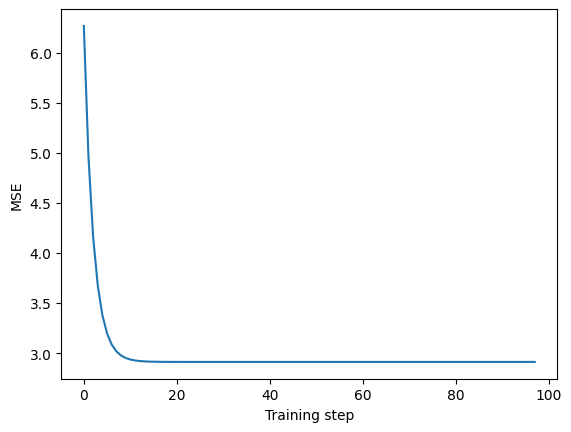

In [135]:

result_sgd = GD(grad_method=loss_grad, X=X, y=y, beta0=beta0, n_epochs=100, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_sgd["loss_list"]

plt.plot(loss_list[3:])
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Stochastic

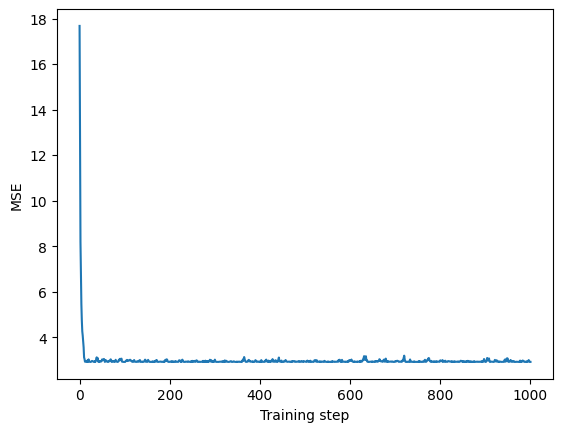

In [136]:

result_sgd = SGD(grad_method=loss_grad, X=X, y=y, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_sgd["loss_list"]


plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Adagrad

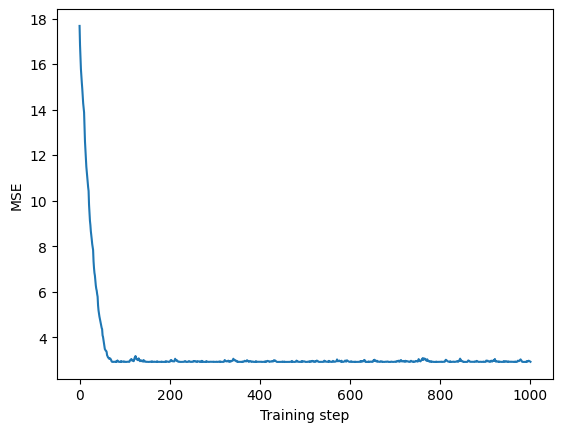

In [137]:

result_adagrad = SGD_adagrad(grad_method=loss_grad, X=X, y=y, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_adagrad["loss_list"]


plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### RMS prop

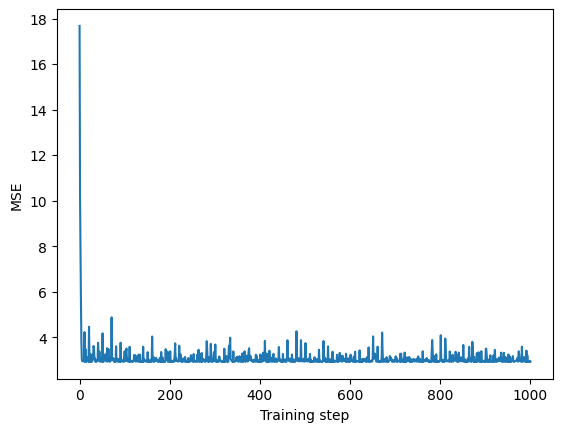

In [138]:

result_rms = SGD_RMS_prop(grad_method=loss_grad, X=X, y=y, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_rms["loss_list"]

plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()

### Adam

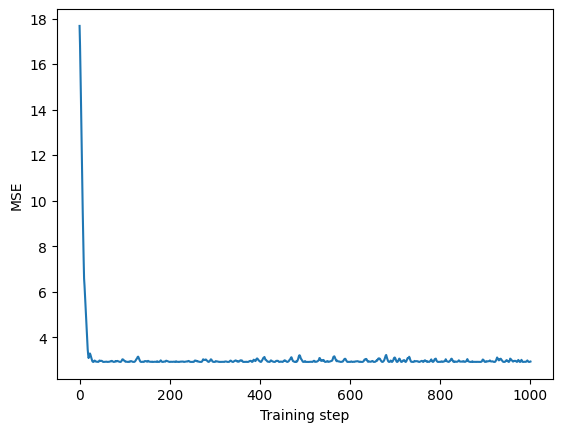

In [139]:


result_adam = SGD_adam(grad_method=loss_grad, X=X, y=y, beta0=beta0, n_epochs=100, batch_size=10, test_loss_func=loss_func, lr=0.01, gamma=0.0)

loss_list = result_adam["loss_list"]

plt.plot(loss_list)
plt.xlabel("Training step")
plt.ylabel("MSE")
plt.show()